# Trénovanie modelu iba na základe DST indexu 48 h dozadu, predikcia súčasnej hodnoty

Súbor: 48_dozadu.ipynb

Program: Hospodárska informatika

Vypracovala: Bc. Veronika Motúzová

Diplomová práca: : Predikcia geomagnetickych búrok pomocou hlbokého učenia

Vedúci diplomovej práce: doc. Ing. Peter Butka, PhD.

Konzultanti: Ing. Viera Maslej Krešňáková, PhD., RNDr. Šimon Mackovjak, PhD. 

### Inštalácia knižníc

In [ ]:
!pip install pyarrow
!pip install keras
!pip install --upgrade tensorflow
!pip install --upgrade tensorflow-gpu

### Kontrola kapacity servera

In [1]:
!nvidia-smi

Mon Feb 27 18:20:34 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.86.01    Driver Version: 515.86.01    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro RTX 4000     Off  | 00000000:8B:00.0 Off |                  N/A |
| 24%   45C    P0    30W / 125W |      0MiB /  8192MiB |      5%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Import knižníc

In [2]:
import pandas as pd
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import seaborn as sns

from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential

from keras.layers import Dense, Activation, Dropout, Input, Conv1D, LSTM, MaxPooling1D, Flatten, TimeDistributed, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import Model


from scipy.special import expit, logit

from sklearn.metrics import confusion_matrix, classification_report, matthews_corrcoef

### Načitanie dát, odstránenie na hodnôt, určenie predikovaného atribútu

In [3]:
train = pd.read_csv('train_omni.csv')
test = pd.read_csv('test_omni.csv')
features = ['time1',
            'DST']
test = test[features]
train = train[features]
train['time1']=pd.to_datetime(train['time1'])
test['time1']=pd.to_datetime(test['time1'])
predicted_label = 'DST'

y_col='DST'
valid_size = int(len(train) * 0.2)
valid = train.iloc[-valid_size:,:].copy()
train = train.iloc[:-valid_size,:].copy()

y_train = train[y_col].values.copy()
X_train = train[y_col].values.copy()
y_val = valid[y_col].values.copy()
X_val = valid[y_col].values.copy()
y_test = test[y_col].values.copy()
X_test = test[y_col].values.copy()

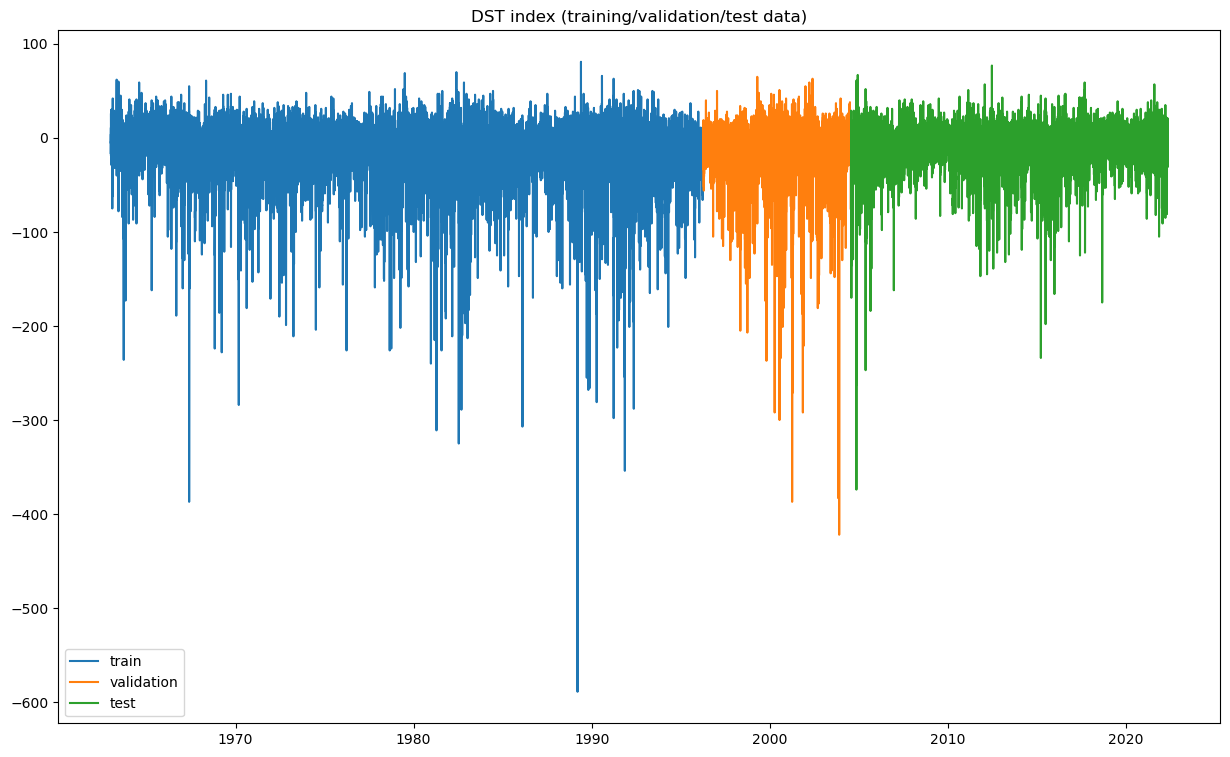

In [4]:
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
%matplotlib inline
register_matplotlib_converters()

plt.rcParams['figure.figsize'] = [15, 9]
plt.figure()
plt.title("DST index (training/validation/test data)")
plt.plot(train['time1'],train['DST'],label='train')
plt.plot(valid['time1'],valid['DST'],label='validation')
plt.plot(test['time1'],test['DST'],label='test')
plt.legend();

In [5]:
# set batch, n_input, n_features

n_input = 48  # how many samples/rows/timesteps to look in the past in order to forecast the next sample
n_features= len(X_train)  # how many predictors/Xs/features we have to predict y
b_size = 256  # Number of timeseries samples in each batch

train_generator = TimeseriesGenerator(X_train, y_train, length=n_input, batch_size=b_size)
val_generator = TimeseriesGenerator(X_val, y_val, length=n_input, batch_size=b_size)
test_generator = TimeseriesGenerator(X_test, y_test, length=n_input, batch_size=256)

In [6]:
print("Počet batchov: ", len(train_generator))
print("Každý batch má features (X zložku) a labels (y zložku): ", len(train_generator[0]))
print("Dĺžka X zložky batchu: ", len(train_generator[0][0]))
print("Dĺžka y zložky batchu (počet meraní v batchi): ",len(train_generator[0][1]))
print("Počet riadkov braných do úvahy pre jedno meranie (koľko sa pozerá dozadu): ", len(train_generator[0][0][0]))

Počet batchov:  1139
Každý batch má features (X zložku) a labels (y zložku):  2
Dĺžka X zložky batchu:  256
Dĺžka y zložky batchu (počet meraní v batchi):  256
Počet riadkov braných do úvahy pre jedno meranie (koľko sa pozerá dozadu):  48


In [7]:
inputs = Input(shape=(n_input,1))
c = Bidirectional(LSTM(128, return_sequences=True, dropout=0.1,recurrent_dropout=0.1))(inputs)
c = LSTM(128, return_sequences=True)(c)
c = TimeDistributed(Dense(1, activation='linear'))(c)
output = Flatten()(c)
output = Dense(1, activation='linear')(output)
model = Model(inputs=inputs, outputs=output)
model.compile(loss='mse', optimizer='adam', metrics=["mae"])
print(model.summary())

2023-02-27 18:20:50.978872: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6674 MB memory:  -> device: 0, name: Quadro RTX 4000, pci bus id: 0000:8b:00.0, compute capability: 7.5


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 1)]           0         
                                                                 
 bidirectional (Bidirectiona  (None, 48, 256)          133120    
 l)                                                              
                                                                 
 lstm_1 (LSTM)               (None, 48, 128)           197120    
                                                                 
 time_distributed (TimeDistr  (None, 48, 1)            129       
 ibuted)                                                         
                                                                 
 flatten (Flatten)           (None, 48)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 49    

In [8]:
# callbacks
saved_model = "48_dozadu.hdf5"
checkpoint = ModelCheckpoint(saved_model, monitor='val_mae', verbose=1, save_best_only=True, mode='min')
early = EarlyStopping(monitor="val_mae", mode="min", patience=25)
callbacks_list = [checkpoint, early]

In [9]:
# fit
history = model.fit(train_generator, validation_data=val_generator, epochs=20, verbose=1, callbacks = callbacks_list)

Epoch 1/20


2023-02-27 18:20:58.575795: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8201


1139/1139 [==============================] - ETA: 0s - loss: 99.3852 - mae: 5.5369
Epoch 1: val_mae improved from inf to 8.10952, saving model to 48_dozadu.hdf5
1139/1139 [==============================] - 464s 402ms/step - loss: 99.3852 - mae: 5.5369 - val_loss: 169.0201 - val_mae: 8.1095
Epoch 2/20
1139/1139 [==============================] - ETA: 0s - loss: 45.1592 - mae: 3.9415
Epoch 2: val_mae improved from 8.10952 to 4.09448, saving model to 48_dozadu.hdf5
1139/1139 [==============================] - 454s 399ms/step - loss: 45.1592 - mae: 3.9415 - val_loss: 42.7037 - val_mae: 4.0945
Epoch 3/20
1139/1139 [==============================] - ETA: 0s - loss: 48.0177 - mae: 3.9818
Epoch 3: val_mae improved from 4.09448 to 3.41136, saving model to 48_dozadu.hdf5
1139/1139 [==============================] - 455s 399ms/step - loss: 48.0177 - mae: 3.9818 - val_loss: 44.8930 - val_mae: 3.4114
Epoch 4/20
1139/1139 [==============================] - ETA: 0s - loss: 38.0708 - mae: 3.5653
Epoch

In [10]:
# load best model
model = keras.models.load_model('48_dozadu.hdf5')

In [11]:
# prediction
y_pred = model.predict(test_generator)

607/607 [==============================] - 39s 62ms/step


In [12]:
y_pred

array([[-34.277103],
       [-30.67907 ],
       [-28.223042],
       ...,
       [-26.859098],
       [-19.42297 ],
       [-20.987818]], dtype=float32)

In [13]:
# confusion matrix
# TN FP
# FN TP

y_pred2 = np.where(y_pred <= -20, 1, 0)
# [n_input:] because prediction starts from n-th row
y_test2 = np.where(y_test[n_input:]  <= -20, 1, 0)

cm = confusion_matrix(y_test2, y_pred2)
print("Confusion matrix: \n" + str(cm))

Confusion matrix: 
[[124043    573]
 [  7357  23238]]


In [14]:
print(classification_report(y_test2, y_pred2))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97    124616
           1       0.98      0.76      0.85     30595

    accuracy                           0.95    155211
   macro avg       0.96      0.88      0.91    155211
weighted avg       0.95      0.95      0.95    155211



In [15]:
df = pd.DataFrame(data={"time": test['time1'][n_input:],"y_true": y_test[n_input:].reshape(-1) , "y_predict": y_pred.reshape(-1)})

In [16]:
df

,time,y_true,y_predict
48,2004-07-23 22:00:00,-34.0,-34.277103
49,2004-07-23 23:00:00,-31.0,-30.679070
50,2004-07-24 00:00:00,-27.0,-28.223042
51,2004-07-24 01:00:00,-19.0,-24.176327
52,2004-07-24 02:00:00,-11.0,-16.489895
...,...,...,...
155254,2022-04-28 20:00:00,-29.0,-22.583319
155255,2022-04-28 21:00:00,-31.0,-25.387426
155256,2022-04-28 22:00:00,-25.0,-26.859098
155257,2022-04-28 23:00:00,-24.0,-19.422970


In [17]:
df.describe()

,y_true,y_predict
count,155211.000000,155211.000000
mean,-9.810922,-8.811703
std,16.324856,14.685791
min,-374.000000,-314.206055
25%,-16.000000,-14.463691
50%,-7.000000,-6.156815
75%,0.000000,-0.187939
max,77.000000,44.911388


<AxesSubplot: >

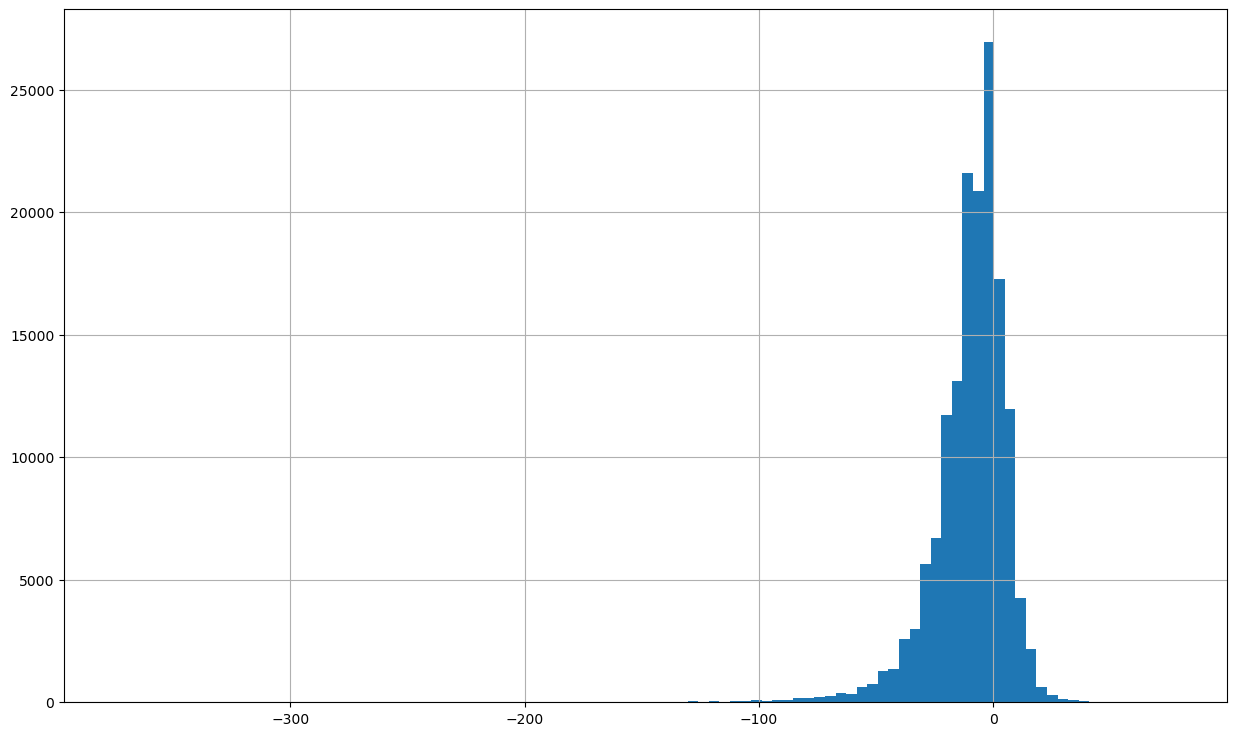

In [18]:
df["y_true"].hist(bins=100)

<AxesSubplot: >

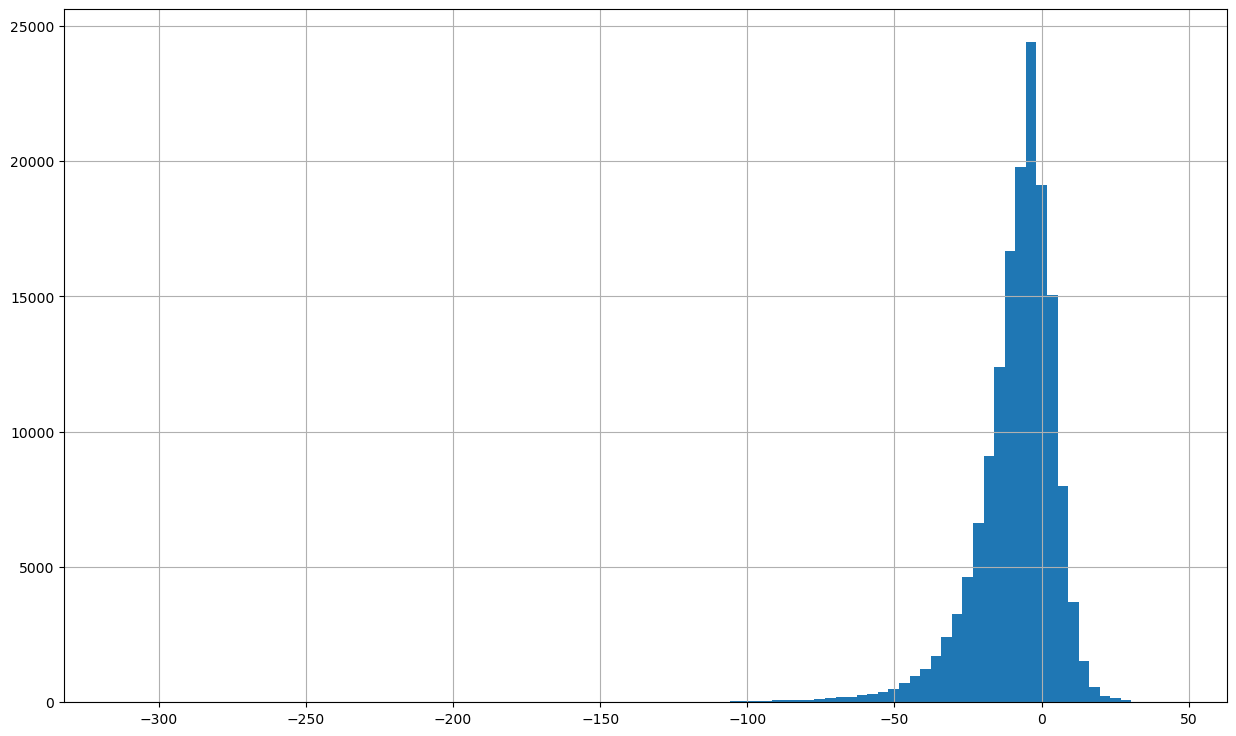

In [19]:
df["y_predict"].hist(bins=100)

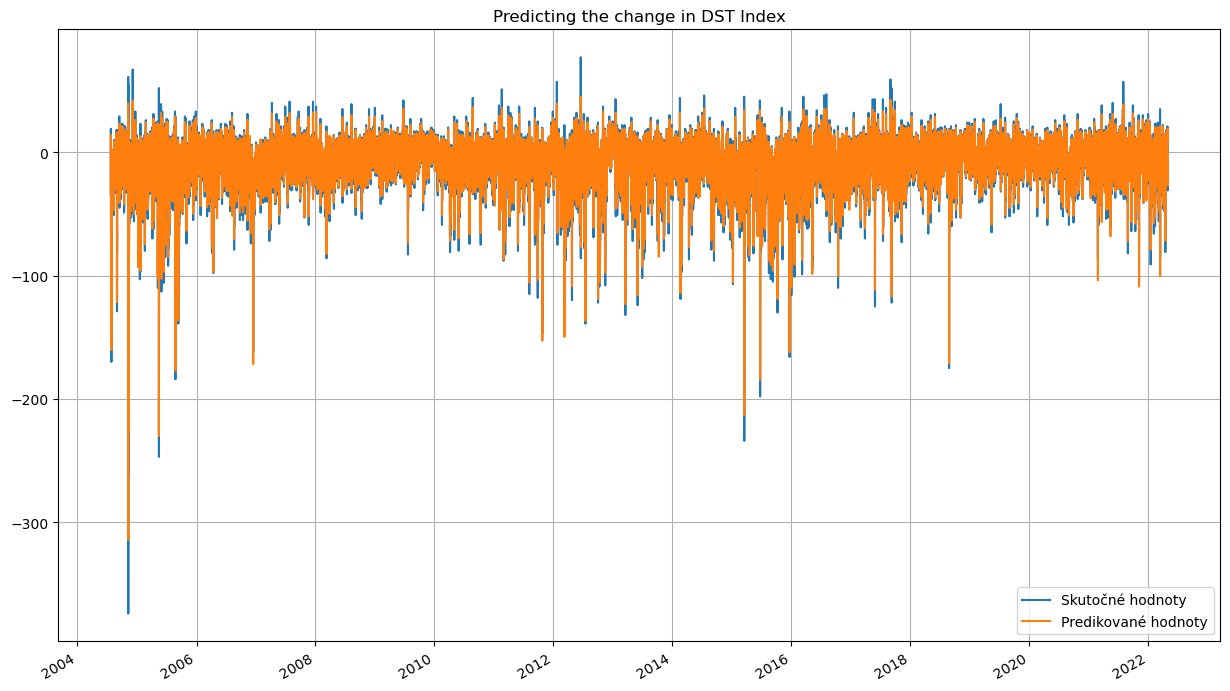

In [20]:
plt.figure()
plt.title('Predicting the change in DST Index')
plt.plot(df['time'],df['y_true'], label='Skutočné hodnoty')
plt.plot(df['time'],df['y_predict'], label='Predikované hodnoty')
plt.legend()
plt.gcf().autofmt_xdate()
plt.grid(True)

In [21]:
df.to_csv('predikcie_48h_dozadu.csv')

In [22]:
TN = cm[0,0] 
print(TN)
FP = cm[0,1]
print(FP)
FN = cm[1,0] 
print(FN)
TP = cm[1,1] 
print(TP)
# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
print("TPR={}".format(TPR))
# Specificity or true negative rate
TNR = TN/(TN+FP)
print("TNR={}".format(TNR))
# Precision or positive predictive value
PPV = TP/(TP+FP)
print("PPV={}".format(PPV))
# Negative predictive value
NPV = TN/(TN+FN)
print("NPV={}".format(NPV))
# Fall out or false positive rate
FPR = FP/(FP+TN)
print("FPR={}".format(FPR))
# False negative rate
FNR = FN/(TP+FN)
print("FNR={}".format(FNR))
# False discovery rate
FDR = FP/(TP+FP)
print("FDR={}".format(FDR))
# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)
print("ACC={}".format(ACC))
MCC = matthews_corrcoef(y_test2, y_pred2)
print("MCC={}".format(MCC))

124043
573
7357
23238
TPR=0.7595358718744893
TNR=0.9954018745586442
PPV=0.975935491999496
NPV=0.9440106544901066
FPR=0.004598125441355845
FNR=0.2404641281255107
FDR=0.02406450800050397
ACC=0.948908260368144
MCC=0.8333679083518309
